In [1]:
%matplotlib inline
#自动补全
%config IPCompleter.greedy=True

In [2]:
import os
import bisect
import datetime
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import gridspec, colors as mcolors
from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.colors import colorConverter
from matplotlib.ticker import FuncFormatter
from pandas import DataFrame
from pymongo import MongoClient

In [3]:
client = MongoClient('127.0.0.1', 27017, username='mjh', password='666666', authSource='stock')
db = client['stock']

daily = DataFrame(
        list(db['daily'].find({'ts_code': '000001.SZ'})),
        columns=['ts_code', 'trade_date', 'open', 'high', 'low', 'close',
                'pre_close', 'change', 'pct_chg', 'vol', 'amount'])

data = daily[daily['trade_date'] > '20180901']
data.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
3936,000001.SZ,20180903,10.09,10.30,10.09,10.19,10.13,0.06,0.5923,711695.67,725303.291
3937,000001.SZ,20180904,10.20,10.55,10.07,10.43,10.19,0.24,2.3553,1296342.08,1339756.563
3938,000001.SZ,20180905,10.30,10.33,10.05,10.05,10.43,-0.38,-3.6433,1179453.17,1202345.697
3939,000001.SZ,20180906,10.05,10.14,9.95,9.97,10.05,-0.08,-0.7960,711777.55,713975.749
3940,000001.SZ,20180907,10.04,10.18,9.93,10.01,9.97,0.04,0.4012,809035.34,815151.722


In [4]:
def candlestick(ax,
                opens,
                highs,
                lows,
                closes,
                width=0.8,
                colorup='r',
                colordown='g',
                alpha=0.75):
    '''绘制K线图'''

    delta = width / 2.

    # 中间的Box
    barVerts = [((i - delta, open), (i - delta, close), (i + delta, close),
                 (i + delta, open))
                for i, open, close in zip(range(len(opens)), opens, closes)]

    # 下影线
    downSegments = [((i, low), (i, min(open, close)))
                    for i, low, high, open, close in zip(
                        range(len(lows)), lows, highs, opens, closes)]

    # 上影线
    upSegments = [((i, max(open, close)), (i, high))
                  for i, low, high, open, close in zip(
                      range(len(lows)), lows, highs, opens, closes)]

    rangeSegments = upSegments + downSegments

    r, g, b = colorConverter.to_rgb(colorup)
    colorup = r, g, b, alpha
    r, g, b = colorConverter.to_rgb(colordown)
    colordown = r, g, b, alpha
    colord = {
        True: colorup,
        False: colordown,
    }
    colors = [colord[open < close] for open, close in zip(opens, closes)]

    useAA = 0,  # use tuple here
    lw = 0.5,  # and here
    rangeCollection = LineCollection(
        rangeSegments,
        colors=((0, 0, 0, 1), ),
        linewidths=lw,
        antialiaseds=useAA,
    )

    barCollection = PolyCollection(
        barVerts,
        facecolors=colors,
        edgecolors=((0, 0, 0, 1), ),
        antialiaseds=useAA,
        linewidths=lw,
    )

    minx, maxx = 0, len(rangeSegments) / 2
    miny = min([low for low in lows])
    maxy = max([high for high in highs])

    corners = (minx, miny), (maxx, maxy)
    ax.update_datalim(corners)
    ax.autoscale_view()

    # add these last
    ax.add_collection(rangeCollection)
    ax.add_collection(barCollection)

    return rangeCollection, barCollection


def volume_overlay(ax,
                   opens,
                   closes,
                   volumes,
                   colorup='r',
                   colordown='g',
                   width=4,
                   alpha=1.0):
    """Add a volume overlay to the current axes.  The opens and closes
    are used to determine the color of the bar.  -1 is missing.  If a
    value is missing on one it must be missing on all

    Parameters
    ----------
    ax : `Axes`
        an Axes instance to plot to
    opens : sequence
        a sequence of opens
    closes : sequence
        a sequence of closes
    volumes : sequence
        a sequence of volumes
    width : int
        the bar width in points
    colorup : color
        the color of the lines where close >= open
    colordown : color
        the color of the lines where close <  open
    alpha : float
        bar transparency

    Returns
    -------
    ret : `barCollection`
        The `barrCollection` added to the axes
    """

    colorup = mcolors.to_rgba(colorup, alpha)
    colordown = mcolors.to_rgba(colordown, alpha)
    colord = {True: colorup, False: colordown}
    colors = [
        colord[open < close] for open, close in zip(opens, closes)
        if open != -1 and close != -1
    ]

    delta = width / 2.
    bars = [((i - delta, 0), (i - delta, v), (i + delta, v), (i + delta, 0))
            for i, v in enumerate(volumes) if v != -1]

    barCollection = PolyCollection(
        bars,
        facecolors=colors,
        edgecolors=((0, 0, 0, 1), ),
        antialiaseds=(0, ),
        linewidths=(0.5, ),
    )

    ax.add_collection(barCollection)
    corners = (0, 0), (len(bars), max(volumes))
    ax.update_datalim(corners)
    ax.autoscale_view()

    # add these last
    return barCollection


def MACD(closes, fastperiod=12, slowperiod=26, signalperiod=9):
    fast_ema = closes.ewm(span=fastperiod).mean()
    slow_ema = closes.ewm(span=slowperiod).mean()
    dif = fast_ema - slow_ema
    dea = dif.ewm(span=signalperiod).mean()
    macd = 2 * (dif - dea)
    return dif, dea, macd

In [5]:
chinese_font = None
chinese_font_path = os.path.abspath("./fonts/MSYH.TTF")
if os.path.exists(chinese_font_path):
    from matplotlib.font_manager import FontProperties
    chinese_font = FontProperties(fname=chinese_font_path)

In [6]:
def drawMA(ax, data, color='white', window=5, line_width=2, label=''):
    ma = pd.Series.rolling(data, window=window).mean()
    ax.plot(ma.values, color=color, lw=line_width, label=label)

    
def drawStockPanel(data, open_column='open', close_column='close',
                   low_column='low', high_column='high', 
                   date_column='trade_date', volume_column='vol',
                   amount_column='amount',
                   colorup='r', colordown='g',
                   price_ma_lines=dict(
                       MA5=dict(color='orange'),
                       MA10=dict(color='blue'),
                       MA20=dict(color='magenta'),
                       MA30=dict(color='cyan'),
                       MA60=dict(color='black'),
                   ),
                   volumn_ma_lines=dict(
                       MA5=dict(color='orange'),
                       MA30=dict(color='cyan'),
                   ),
                   macd_lines=dict(
                       DIF=dict(color='orange'),
                       DEA=dict(color='cyan'),
                   ),
                   title=''):
    '''绘制股票面板，包含K线图、成交量图和MACD图'''
    
    if not isinstance(data, DataFrame):
        raise ValueError('data must be a pandas.DataFrame!')
        
    data.sort_values(by=[date_column], ascending=True, inplace=True)
    
    fig = plt.figure(figsize=(10, 16))
    fig.subplots_adjust(bottom=0.1)
    fig.subplots_adjust(hspace=0)
    gs = gridspec.GridSpec(3, 1, height_ratios=[4, 1, 1])
    
    ax0 = plt.subplot(gs[0])
    
    candles = candlestick(ax0, data[open_column], data[high_column],
                          data[low_column], data[close_column],
                          colorup=colorup, colordown=colordown)
    for k, v in price_ma_lines.items():
        if k.startswith('MA'):
            win=int(k[2:])
            drawMA(ax0, data[close_column], color=v['color'],
                   window=win, line_width=2, label=k)
        
    ax0.tick_params(axis='y', labelcolor='white', labelsize=14,
                    width=2, length=8, direction='in')
    ax0.set_ylabel('价格' if chinese_font else 'Price',
                   color='white',
                   fontproperties=chinese_font, fontsize=16)
    ax0.grid(linestyle='-.')
        
    ax1 = plt.subplot(gs[1], sharex=ax0)
    
    vol = volume_overlay(ax1, data[open_column], data[close_column],
        data[volume_column], colorup=colorup, colordown=colordown,
        width=1)
    for k, v in volumn_ma_lines.items():
        if k.startswith('MA'):
            win=int(k[2:])
            drawMA(ax1, data[volume_column], color=v['color'],
                   window=win, line_width=2, label=k)
    
    ax1.tick_params(axis='y', labelcolor='white', labelsize=14,
                    width=2, length=8, direction='in')
    ax1.set_ylabel('成交量' if chinese_font else 'Volume',
                   color='white',
                   fontproperties=chinese_font, fontsize=16)
    ax1.grid(linestyle='-.')
    
    ax2 = plt.subplot(gs[2], sharex=ax0)
    
    dif, dea, macd = MACD(data[close_column])
    ax2.plot(dif.values, color=macd_lines['DIF']['color'], lw=2)
    ax2.plot(dea.values, color=macd_lines['DEA']['color'], lw=2)
    bars = ax2.bar(range(len(macd)), macd.values, width=0.6)
    for b in bars:
        if b.get_height() > 0:
            b.set_color(colorup)
        else:
            b.set_color(colordown)
    
    ax2.tick_params(axis='y', labelcolor='white', labelsize=14,
                    width=2, length=8, direction='in')
    ax2.set_ylabel('MACD', color='white',
                   fontproperties=chinese_font, fontsize=16)
    ax2.grid(linestyle='-.')
            
    dates = [str(d.date()) for d in pd.to_datetime(data['trade_date'])]
    tickdates = pd.date_range(dates[0], dates[-1], freq='W-MON')
    tickindex = [bisect.bisect_left(dates, str(d.date())) for d in tickdates]
    ticknames = [str(d.date()) for d in tickdates]
    ax2.set_xticks(tickindex)
    ax2.set_xticklabels(ticknames)
    ax2.tick_params(axis='x', labelcolor='white', labelsize=14,
                    width=2, length=8, direction='in')
    for xlabel in ax2.get_xticklabels():
        xlabel.set_rotation(45)
        xlabel.set_horizontalalignment('right')
    ax2.set_xlabel('日期' if chinese_font else 'Date',
                   color='white',
                   fontproperties=chinese_font, fontsize=16)

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


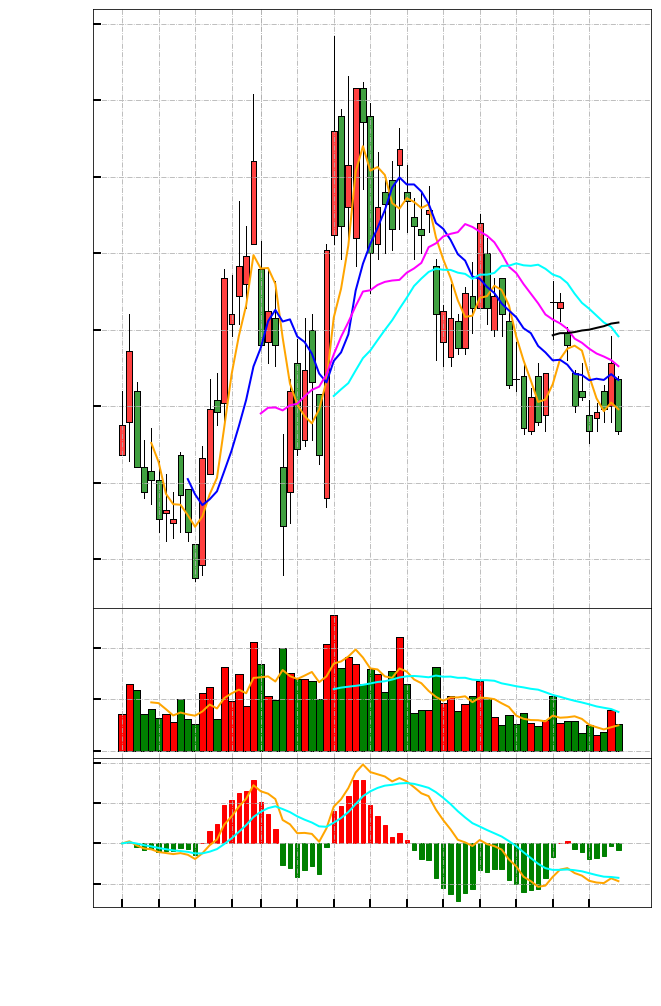

In [7]:
drawStockPanel(data)

In [8]:
!cat chart.py

#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os
import sys
import datetime
import numpy as np

# MatPlotLib 的主要模組
import matplotlib.pyplot as plt

# 畫圖形週邊東西的套件
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter

import bisect

# 畫圖用的套件
from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.colors import colorConverter
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib import colors as mcolors

from dateutil.parser import parse

# 讀股價歷史資料
#import pandas_datareader.data as web

import pandas as pd

has_chinese_font = False
chinese_font_path = r"c:\windows\fonts\simsun.ttc"
if os.path.exists(chinese_font_path):
    from matplotlib.font_manager import FontProperties
    font = FontProperties(fname=chinese_font_path, size=24)
    has_chinese_font = True


def candlestick(ax,
                opens,
                highs,
                lows,
                closes,
                width=4,